In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# jax
from jax import numpy as jnp
# numpy
import numpy as np
import random
import matplotlib.pyplot as plt
# utils
from tqdm.notebook import tqdm
import pickle
# custom modules
from canvas import *
from placer import *
from box import *
from net import *
from neuroPlacer import *
from VAEPlacer import *

## Pseudo Testcase Generation

number of boxes: 10 10
number of nets: 2 2
net_0 box_0 ['box_0', 'box_2', 'box_4', 'box_6', 'box_8']
net_1 box_1 ['box_1', 'box_3', 'box_5', 'box_7', 'box_9']


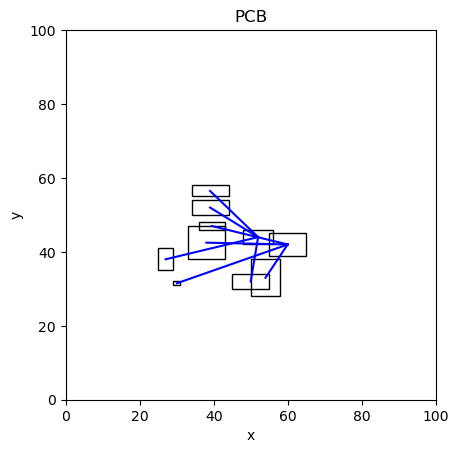

In [2]:
# make some boxes and nets
box_collection = {}
net_collection = {}

num_boxes = 10
num_nets = 2

# generate 10 boxes and 3 nets
for i in range(0, num_boxes):
    net_idx = int(i % num_nets)
    box_collection[f"box_{i}"] = Box(
        box_name=f"box_{i}",
        llx=random.randint(25, 55),
        lly=random.randint(25, 55),
        width=random.randint(1, 10),
        height=random.randint(1, 10),
        net_name=f"net_{net_idx}",
    )

    if f"net_{net_idx}" not in net_collection:
        net_collection[f"net_{net_idx}"] = Net(
            net_name=f"net_{net_idx}", source_box_name=f"box_{i}", sink_box_names=[]
        )
    else:
        net_collection[f"net_{net_idx}"].add_sink_box_name(f"box_{i}")

# make a canvas
pcb_canvas = PCBCanvas(width=100, height=100, boxes=box_collection, nets=net_collection)
print("number of boxes:", len(pcb_canvas.boxes), len(box_collection))
for box in pcb_canvas.boxes.values():
    print(box)
print("number of nets:", len(pcb_canvas.nets), len(net_collection))
for net in pcb_canvas.nets.values():
    print(net.net_name, net.source_box_name, net.box_names)

pcb_canvas.plot()
# print(pcb_canvas.get_incidence_matrix())

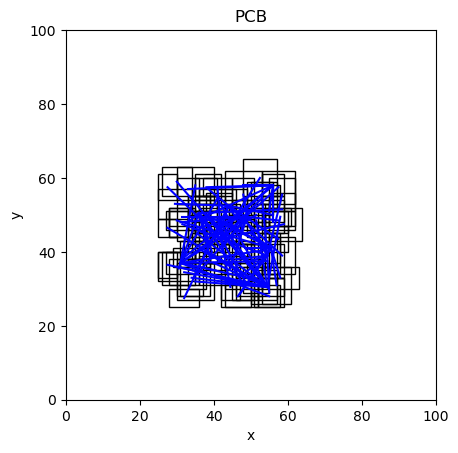

wirelength:	 1460.9302497417136


In [3]:
# pickle the canvas
pickle_id = '09'
# with open(f"./testcase/pcb_canvas_{pickle_id}.pkl", "wb") as f:
#     pickle.dump(pcb_canvas, f)
# load the canvas
with open(f"./testcase/pcb_canvas_{pickle_id}.pkl", "rb") as f:
    pcb_canvas = pickle.load(f)

pcb_canvas.plot()
print("wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

In [4]:
# extract the current canvas dimension
canvas_width = pcb_canvas.width
canvas_height = pcb_canvas.height
# canvas dimension (maxX, maxY, minX, minY)
canvas_dim = pcb_canvas.get_canvas_dim()
maxX, maxY, minX, minY = canvas_dim
compx = pcb_canvas.get_cxy()[:, 0]
compx_jnp = jnp.array(compx)

compy = pcb_canvas.get_cxy()[:, 1]
compy_jnp = jnp.array(compy)

comph = pcb_canvas.get_all_boxes_width()
comph_jnp = jnp.array(comph)

compw = pcb_canvas.get_all_boxes_height()
compw_jnp = jnp.array(compw)

num_bin_x = 10
num_bin_y = 10

# [Net to pin coord] mapping 
net_to_pin_coords = {}
for net in pcb_canvas.nets.values():
    for box_name in net.box_names:
        if net.net_name not in net_to_pin_coords:
            net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
        else:
            net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

print("net to pin coords:")
for net, pin_coords in net_to_pin_coords.items():
    print(net, pin_coords)

# [Net to pin coord] mapping
net_to_insts = {}
for net in pcb_canvas.nets.values():
    net_to_insts[net.net_name] = net.box_names

print("net to insts:")
for net, insts in net_to_insts.items():
    print(net, insts)


2023-12-07 14:37:38.343421: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25390809088
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


net to pin coords:
net_0 [array([54.5, 30.5]), array([32. , 34.5]), array([41.5, 53.5]), array([27.5, 46.5]), array([51.5, 48.5]), array([58. , 49.5]), array([27.5, 36.5]), array([45. , 43.5]), array([38.5, 49.5]), array([35.5, 45. ])]
net_1 [array([54.5, 39. ]), array([31.5, 47.5]), array([58.5, 55.5]), array([48. , 49.5]), array([50. , 37.5]), array([55., 29.]), array([46., 38.]), array([48., 34.]), array([46.5, 28. ]), array([53. , 55.5])]
net_2 [array([31., 37.]), array([54.5, 37.5]), array([54. , 40.5]), array([40.5, 35. ]), array([51.5, 32.5]), array([42.5, 45.5]), array([35., 58.]), array([41. , 54.5]), array([51.5, 50. ]), array([55., 28.])]
net_3 [array([54.5, 30.5]), array([53.5, 30.5]), array([30., 36.]), array([41.5, 48. ]), array([30., 59.]), array([35., 32.]), array([40., 37.]), array([34., 33.]), array([39. , 49.5]), array([36.5, 40.5])]
net_4 [array([42. , 43.5]), array([53. , 54.5]), array([44.5, 30.5]), array([57.5, 57.5]), array([27.5, 57.5]), array([48.5, 32. ]), ar

# Placement Stage

wirelength:	 1460.9302497417136


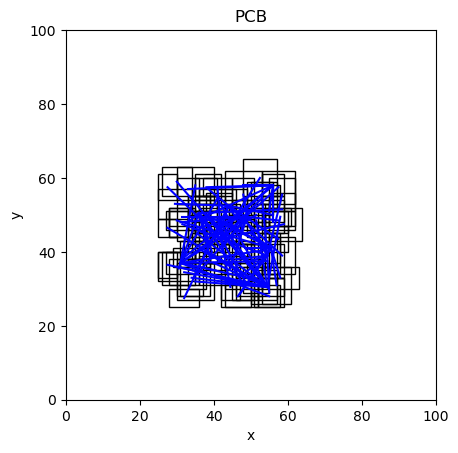

****************************************************
Weighted-average wirelength_2 grad:
 {'box_0': Array([ 2.586637 , -2.5960834], dtype=float32), 'box_10': Array([-0.4352616 ,  0.07991475], dtype=float32), 'box_20': Array([-0.25710005,  0.44427794], dtype=float32), 'box_30': Array([-0.5148604 ,  0.31462133], dtype=float32), 'box_40': Array([-0.05996403,  0.35237265], dtype=float32), 'box_50': Array([0.06994301, 0.371049  ], dtype=float32), 'box_60': Array([-0.5148604 ,  0.11971256], dtype=float32), 'box_70': Array([-0.1888631 ,  0.25710014], dtype=float32), 'box_80': Array([-0.31462148,  0.371049  ], dtype=float32), 'box_90': Array([-0.37104893,  0.28598583], dtype=float32), 'box_1': Array([ 1.062012 , -0.4591244], dtype=float32), 'box_11': Array([-0.4442779 ,  0.16918468], dtype=float32), 'box_21': Array([0.07991463, 0.3241071 ], dtype=float32), 'box_31': Array([-0.1296348 ,  0.20846671], dtype=float32), 'box_41': Array([-0.0898785 , -0.02999553], dtype=float32), 'box_51': Array([ 0

In [5]:
# make a placer
pcbplacer = PCBPlacer(pcb_canvas)
pin_grad_to_inst = {} # aggregate the pin gradients for each instance

# init placement
# pcbplacer.init_plc_spectral()
print("wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
pcb_canvas.plot()
WA_sum = 0
#### WA objective for each net
print("****************************************************")
print("Weighted-average wirelength_2 grad:\n", pcbplacer.Wa_obj_grad(
    net_to_pin_coords=net_to_pin_coords,
    net_to_insts=net_to_insts, SMOOTHNESS = 50))

print("HPWL objective grad: \n", pcbplacer.HPWL_obj_grad( net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, verbose=False))


#### Density objective
print("****************************************************")
# print("Weighted-average wirelength_2:\n", pcbplacer.wirelength_objective_fn(
#     net_to_pin_coords=net_to_pin_coords,
#     net_to_insts=net_to_insts))
# print("Weighted-average wirelength_2 grad:\n", pcbplacer.wirelength_objective_fn_grad_jax(
#     net_to_pin_coords=net_to_pin_coords,
#     net_to_insts=net_to_insts, verbose=False))
print("Density objective: \n", pcbplacer.Grid_density_obj(
    compx_=compx,
    compy_=compy,
    compw_=compw,
    comph_=comph,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
))

print("compx: ", compx)
print("compy: ", compy)
print("Density objective grad: \n", pcbplacer.Grid_density_obj_grad(
    compx_=compx_jnp,
    compy_=compy_jnp,
    compw_=compw_jnp,
    comph_=comph_jnp,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
    verbose=True,
))

In [6]:
%%script false --no-raise-error
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
print(
    "Before density:\t",
    pcbplacer.Grid_density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    ),
)

# clear the plot folder
for f in os.listdir("./plot/grad_density/"):
    os.remove(os.path.join("./plot/grad_density/", f))

# iteratively update the placement with only density objective
for i in tqdm(range(0, 100)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_density/placement_{i}.png")

    # compute the gradient
    density_grad = pcbplacer.Grid_density_obj_grad(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
        verbose=False,
    )

    # update the placement
    for grad in density_grad.keys():
        cx, cy = pcb_canvas.get_box_cxy(grad)
        if_move_x, if_move_y = pcbplacer.check_boundary(
            cx,
            cy,
            pcb_canvas.get_box_width(grad),
            pcb_canvas.get_box_height(grad),
            100 * density_grad[grad][0],
            100 * density_grad[grad][1],
            minX,
            minY,
            maxX,
            maxY,
        )

        if if_move_x:
            cx -= 100 * density_grad[grad][0]
        if if_move_y:
            cy -= 100 * density_grad[grad][1]

        pcb_canvas.set_box_cxy(grad, cx, cy)

    # update net_to_pin_coords
    compx = pcb_canvas.get_cxy()[:, 0]
    compy = pcb_canvas.get_cxy()[:, 1]

print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
print(
    "After density:\t",
    pcbplacer.Grid_density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    ),
)

# generate the placement gif
pcb_canvas.generate_gif_from_plots("grad_density", "placement_density_grad.gif")

In [7]:
%%script false --no-raise-error
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
# clear the plot folder
for f in os.listdir("./plot/grad_HPWL/"):
    os.remove(os.path.join("./plot/grad_HPWL/", f))

# iterate only with Wa_obj_grad and update the location of the instances
for i in tqdm(range(0, 10)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_HPWL/placement_{i}.png")

    # compute the gradient
    HPWL_grad = pcbplacer.HPWL_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts
    )

    # print("HPWL_grad length:", len(HPWL_grad))
    for grad in HPWL_grad.keys():
        cx, cy = pcb_canvas.get_box_cxy(grad)
        pcb_canvas.set_box_cxy(
            grad, cx - 0.1 * HPWL_grad[grad][0], cy - 0.1 * HPWL_grad[grad][1]
        )

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

    # print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots("grad_HPWL", "placement_HPWL_grad.gif")

In [8]:
%%script false --no-raise-error
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
# clear the plot folder
for f in os.listdir("./plot/grad_Wa/"):
    os.remove(os.path.join("./plot/grad_Wa/", f))

# iterate only with Wa_obj_grad and update the location of the instances
for i in tqdm(range(0, 10)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_Wa/placement_{i}.png")

    # compute the gradient
    Wa_obj_grad = pcbplacer.Wa_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS = 50
    )

    for grad in Wa_obj_grad.keys():
        print(grad, Wa_obj_grad[grad])
        cx, cy = pcb_canvas.get_box_cxy(grad)
        pcb_canvas.set_box_cxy(
            grad, cx -  Wa_obj_grad[grad][0], cy -  Wa_obj_grad[grad][1]
        )

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

    print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots("grad_Wa", "placement_Wa_grad.gif")

## Gradient-based Placement 

In [9]:
# %%script false --no-raise-error
lambda_Density = 0.01
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

# clear the plot folder
for f in os.listdir("./plot/grad_09/"):
    os.remove(os.path.join("./plot/grad_09/", f))

prev_Wa_obj = pcbplacer.Wa_obj(
    net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS=50
)
prev_Density_obj = pcbplacer.Density_obj(
    compx_=compx,
    compy_=compy,
    compw_=compw,
    comph_=comph,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
)

# iterate only with Wa_obj_grad & Density_obj_grad and update the location of the instances
for i in tqdm(range(0, 5000)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_09/placement_{i}.png")

    # compute the gradient
    Wa_obj_grad = pcbplacer.Wa_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS=50
    )
    Density_obj_grad = pcbplacer.Density_obj_grad(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
        verbose=False,
    )

    # if nan density gradient, then set to 0
    for grad in Density_obj_grad.keys():
        if np.isnan(Density_obj_grad[grad][0]) or np.isnan(Density_obj_grad[grad][1]):
            Density_obj_grad[grad] = np.array([1e6, 1e6])

    # compute the gradient
    for Wa_grad, Density_grad in zip(Wa_obj_grad.keys(), Density_obj_grad.keys()):
        # print(grad, Wa_obj_grad[grad])
        cx, cy = pcb_canvas.get_box_cxy(Wa_grad)
        # dynamically scale the lambda_Density based on the scale of the Wa_obj_grad
        # lambda_Density = np.linalg.norm(Wa_obj_grad[Wa_grad]) / np.linalg.norm(Density_obj_grad[Density_grad])

        total_grad = -1 * (
            Wa_obj_grad[Wa_grad] + lambda_Density * Density_obj_grad[Density_grad]
        )

        if_move_x, if_move_y = pcbplacer.check_boundary(
            cx,
            cy,
            pcb_canvas.get_box_width(Wa_grad),
            pcb_canvas.get_box_height(Wa_grad),
            total_grad[0],
            total_grad[1],
            minX,
            minY,
            maxX,
            maxY,
        )
        # print(f"    [INFO] total_grad: {total_grad}, wa_grad: {Wa_obj_grad[Wa_grad]}, density_grad: {lambda_Density * Density_obj_grad[Density_grad]}")

        if if_move_x:
            cx += total_grad[0]
        if if_move_y:
            cy += total_grad[1]

        pcb_canvas.set_box_cxy(Wa_grad, cx, cy)

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))
    
    #update compx, compy
    compx = pcb_canvas.get_cxy()[:, 0]
    compy = pcb_canvas.get_cxy()[:, 1]

    # reevaluate the density objective
    Density_obj = pcbplacer.Density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    )

    # reevaluate the wirelength objective
    Wa_obj = pcbplacer.wirelength_objective_fn(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts
    )

    print(f"    [INFO] Wa_obj: {Wa_obj}, Density_obj: {Density_obj}")

    # check the convergence
    if (
        abs(prev_Wa_obj - Wa_obj) < 100
        and abs(prev_Density_obj - Density_obj) < 100
    ):
        print("Converged!")
        break

    prev_Wa_obj = Wa_obj
    prev_Density_obj = Density_obj

    # print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots("grad_09", "placement_09_grad.gif")

Before wirelength:	 1460.9302497417136


/tmp/ipykernel_3018764/674176691.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, 5000)):


  0%|          | 0/5000 [00:00<?, ?it/s]

    [INFO] Wa_obj: 14191.202215396106, Density_obj: 733551.125
    [INFO] Wa_obj: 16779.26700987682, Density_obj: 388291.875
    [INFO] Wa_obj: 18321.58016588918, Density_obj: 302931.1875
    [INFO] Wa_obj: 19919.18795400851, Density_obj: 235205.03125
    [INFO] Wa_obj: 20683.117122713593, Density_obj: 216795.25
    [INFO] Wa_obj: 20927.136566386675, Density_obj: 221301.359375
    [INFO] Wa_obj: 20647.59187555313, Density_obj: 192480.84375
    [INFO] Wa_obj: 20870.66512107849, Density_obj: 225436.328125
    [INFO] Wa_obj: 20393.702471017838, Density_obj: 203597.3125
    [INFO] Wa_obj: 20509.542779684067, Density_obj: 242176.859375
    [INFO] Wa_obj: 20626.912733078003, Density_obj: 257363.75
    [INFO] Wa_obj: 21209.682500839233, Density_obj: 196320.3125
    [INFO] Wa_obj: 21152.55802631378, Density_obj: 196453.65625
    [INFO] Wa_obj: 21376.98693561554, Density_obj: 177857.078125
    [INFO] Wa_obj: 21393.30009675026, Density_obj: 153957.75
    [INFO] Wa_obj: 20973.50188779831, Density

KeyboardInterrupt: 

In [ ]:
pcb_canvas.generate_gif_from_plots("grad_09", "placement_09_grad.gif")